# Did the Industrial Revolution Cause an Increase in Global Temperatures?

## Introduction

Global warming and rising temperatures is one of the biggest topics in modern media and politics. The threat of climate change and its consequences due to increasing worldwide temperatures is embedded in the public consciousness, and is a source of great upheaval and debate.

The trends of increasing temperatures with the emission of greenhouse gases is well-documented - 97% of climate scientists agree that the change is happening. It is impossible to refute the existence of global warming.

This project aims to investigate whether the Industrial Revolution that begin in Britain in the 18th century is a direct cause of the rising global temperatures. For the sake of this project, the generally accepted end date of the Industrial Revolution as 1840 will be used to assess the data.

## Data Source

The project uses the Climate Change: Earth Surface Temperature Data dataset from Berkeley Earth, uploaded to Kaggle.
For our purposes, we are only using the Global Temperatures csv. as we are not investigating differences in geographic location.

## Loading Libraries and Data

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as stats
from sklearn.linear_model import LinearRegression

In [2]:
global_temp = pd.read_csv("GlobalTemperatures.csv")

## Initial Data Exploration

In [3]:
global_temp.head()
global_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


The file contains data with 9 columns and 3129 rows, however the first 10 rows show that most of the columns are missing data.

For the purposes of this project, we only need the Date and Average Land Temperature. We can therefore drop the remaining columns and rename the remaining ones to make them clearer.

In [6]:
global_temp = global_temp[['dt','LandAverageTemperature','LandAverageTemperatureUncertainty']]
global_temp.columns = ['date','avg_temp','uncertainty']
global_temp

,date,avg_temp,uncertainty
0,1750-01-01,3.034,3.574
1,1750-02-01,3.083,3.702
2,1750-03-01,5.626,3.076
3,1750-04-01,8.490,2.451
4,1750-05-01,11.573,2.072
...,...,...,...
3187,2015-08-01,14.755,0.072
3188,2015-09-01,12.999,0.079
3189,2015-10-01,10.801,0.102
3190,2015-11-01,7.433,0.119


The `date` column now needs to be converted to a datetime data type, and add a new column `Industrial_Revolution` that determines whether a measurement is before the Industrial Revolution (1840) or after.

In [7]:
global_temp['date'] = pd.to_datetime(global_temp['date']) #dropping null values

global_temp['Industrial_Revolution'] = global_temp['date'] > pd.Timestamp('1840-01-01')


We can drop the NA values from our data frame, and then we have the `date`, `avg_temp` and `uncertainty` columns ready for analysis.

In [8]:
global_temp.dropna(inplace = True)
global_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3180 entries, 0 to 3191
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   3180 non-null   datetime64[ns]
 1   avg_temp               3180 non-null   float64       
 2   uncertainty            3180 non-null   float64       
 3   Industrial_Revolution  3180 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2)
memory usage: 102.5 KB


## Plotting the Data

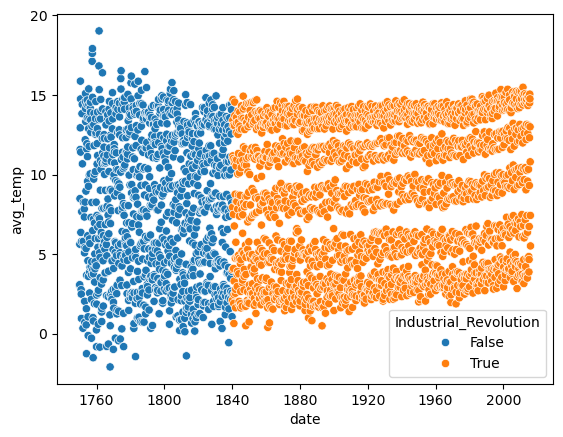

In [18]:
plt.figure()
sns.scatterplot(x = 'date', y = 'avg_temp', hue = 'Industrial_Revolution',
                data = global_temp)

plt.show()

The plot shows an interesting spread in the data. The initial distribution of temperatures is noisy and doesn't show an obvious pattern. The quality and consistency of the data measurements two hundred years ago could cause this inconsitency in the data.

Another feature that is clear from the visualisation is the seperation of the average temperatures into horizontal bands. There a couple of possible explanations for this.

Firstly, the rounding of the temperatures in the measurements could lead to some values being omitted. Secondly, due to the temperature being measured only once per month, there will be seasonal variations that are not picked up due to an insufficient sample of data. The jump between each band likely signifies these seasonal effects.


To negate these effects and make the overall trend of the data easier to visualise, it may be worth only finding the average temperature of each year.

We can create a new `year` column which we can then use in groupby, applying the mean aggregate function.
However, when calculating the uncertainties, the uncertainty of the mean temperature is **not** equal to the mean of the uncertainty values.

Taking the mean of a set of results tends to **reduce** the overall uncertainty, as the random uncertainties in each measurement cancel each other out.

We then need to combine errors in *quadrature* using the following formula:


$$u_{\text{year}} = \sqrt{\frac{\sum_{i=1}^n u_i^2}{n^2}}
$$


In [24]:
global_temp['year'] = global_temp['date'].dt.year
# Define a custom function for uncertainty propagation
# This example uses quadrature sum
def uncertainty_propagation(uncertainties):
    # For example, using quadrature sum: sqrt(u1² + u2² + ...)
    import numpy as np
    return np.sqrt(np.sum(np.square(uncertainties)) / len(uncertainties)**2)
    # Note: Adjust this formula according to your specific uncertainty propagation rules

# Group by year with custom aggregation
yearly_temp = global_temp.groupby('year').agg({
    'avg_temp': 'mean',
    'uncertainty': uncertainty_propagation  # Apply custom function to uncertainty column
}).reset_index()

yearly_temp['Industrial_Revolution'] = yearly_temp['year'] >= 1840
yearly_temp

,year,avg_temp,uncertainty,Industrial_Revolution
0,1750,8.719364,0.816842,False
1,1751,7.976143,1.080112,False
2,1752,5.779833,1.228353,False
3,1753,8.388083,0.970134,False
4,1754,8.469333,1.091063,False
...,...,...,...,...
261,2011,9.516000,0.024364,True
262,2012,9.507333,0.024720,True
263,2013,9.606500,0.028554,True
264,2014,9.570667,0.026515,True


Let's plot another plot, this time using using the `year` column and the associated uncertainties:

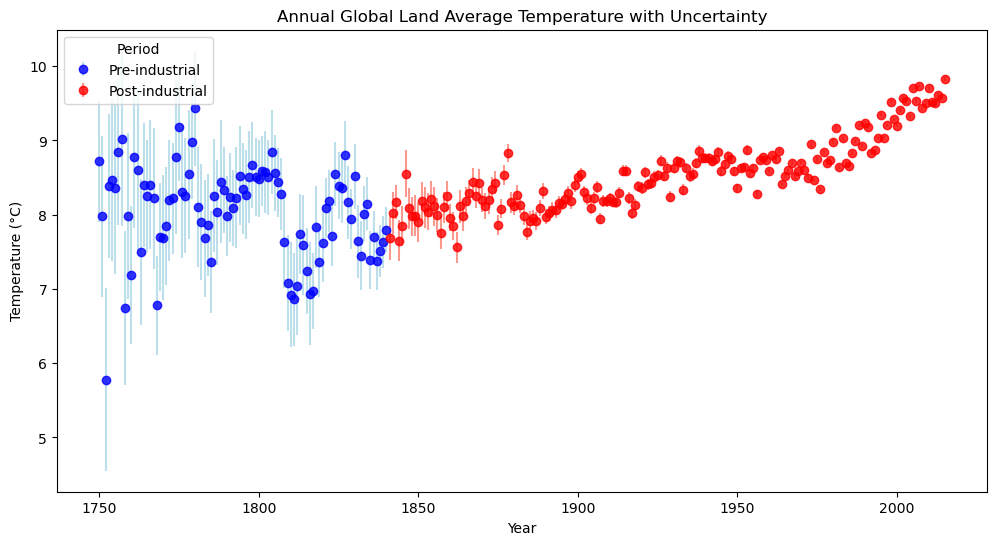

In [34]:
# Split data into pre- and post-1840
pre = yearly_temp[yearly_temp['year'] <= 1840]
post = yearly_temp[yearly_temp['year'] > 1840]

plt.figure(figsize=(12,6))

# Pre-industrial
plt.errorbar(
    pre['year'], pre['avg_temp'],
    yerr=pre['uncertainty'],
    fmt='o', color='blue', ecolor='lightblue',
    alpha=0.8, label='Pre-industrial'
)

# Post-industrial
plt.errorbar(
    post['year'], post['avg_temp'],
    yerr=post['uncertainty'],
    fmt='o', color='red', ecolor='salmon',
    alpha=0.8, label='Post-industrial'
)

plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Annual Global Land Average Temperature with Uncertainty")
plt.legend(title="Period")
plt.show()

## Hypothesis Testing

It appears from the plot that the average global temperature has been steadily increasing since around the turn of the Industrial Revolution.

The next step in the analysis will be to perform a hypothesis test to see whether the data does suggest a significant **linear** relationship in **temperature** over time.

We are going to do this only using **post-1840** data. The reason for this is the high values of uncertainty in the early data, and this is standard practise in climate modelling.

We will do this using a Linear Regression model, with the null hypothesis that there is no linear progression of temperature over time (gradient = 0) and a threshold value of 0.05.


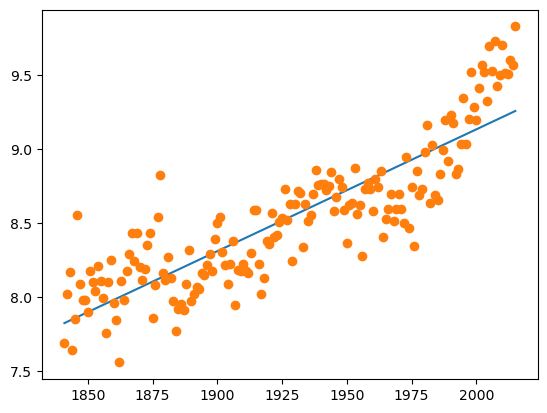

In [59]:
line_fitter = LinearRegression()
# Reshape the features (post.year) to a 2D array using reshape(-1, 1)
# This converts the 1D Series to a 2D array with one column
line_fitter.fit(post.year.values.reshape(-1, 1), post.avg_temp)

# For prediction, we need to use the same features (post.year) reshaped
temp_predict = line_fitter.predict(post.year.values.reshape(-1, 1))

plt.plot(post.year, temp_predict)
plt.plot(post.year, post.avg_temp, 'o')
plt.show()



In [61]:
#using scipy to extract scores from the model and find if the p-value is below the threshold value of 0.05

from scipy.stats import linregress

# Extract year and temp
X = post['year'].values
y = post['avg_temp'].values

# Run regression with scipy
slope, intercept, r_value, p_value, std_err = linregress(X, y)

print(f"Slope: {slope:.4f} °C/year")
print(f"Intercept: {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"P-value for slope: {p_value:.4e}")

Slope: 0.0082 °C/year
Intercept: -7.3536
R²: 0.7511
P-value for slope: 3.9761e-54


## Conclusions

Our linear regression model suggests a fairly strong linear relationship of temperature over time, giving an R squared value of 0.75. The p-value is far below the threshold of 0.05, and we can thus reject the null hypothesis and accept the alternative hypothesis that there is a positive linear relationship.

However, we need to conduct Causal Inference analysis to judge whether there is in fact a causal relationship between the end of the Industrial Revolution in 1840 leading to a change in the trend of average temperatures.

This analysis will be completed using code in R, thus ending this portion of the project.

In [63]:
yearly_temp.to_csv("GlobalTemperaturesCleaned.csv")